In [1]:
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
import cv2
import matplotlib.pyplot as plt

def show_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16,6))
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    else:
        print('Frame not found')

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return ret, frame
    else:
        return ret, None

def crop_frame(frame, x, y, w, h, show=False):
    cropped = frame[x:x+w, y:y+h, :]
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(cropped)
        plt.axis('off')
        plt.show()
    return cropped

def crop_and_save_video(cap, x, y, w, h, output_file, begin_frame=False, end_frame=False):
    fourcc = cv2.VideoWriter_fourcc(*'h264')
    if not output_file.endswith('.mp4'):
        output_file += '.mp4'
    out = cv2.VideoWriter(output_file, # or .mkv
        fourcc, cap.get(cv2.CAP_PROP_FPS),
        (h, w))
    if not begin_frame:
        begin_frame = 0
    if not end_frame:
        end_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    for i in range(begin_frame, end_frame):
        ret, frame = get_frame(cap, i)
        if ret:
            frame = crop_frame(frame, x, y, w, h)
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)
        else:
            break
    out.release()
    cv2.destroyAllWindows()

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from tqdm.notebook import tqdm

def get_sobel(image, kernel_size=5, threshold=5000, kx=1, ky=1, crop=5, show=False):
    """Parameters:
    image: input image (RGB or grayscale)
    kernel_size: size of the Sobel kernel
    threshold: threshold for the Sobel filter
    kx: when kx is high, the filter is more sensitive to vertical edges
    ky: when ky is high, the filter is more sensitive to horizontal edges
    crop: borders to paint in black(list or int)
    """
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        pass
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel = np.sqrt(kx*sobelx**2 + ky*sobely**2) # Sobel filter with kx and ky weights
    sobel[sobel <= threshold] = 255 # thresholding, we want edges to be black for the next steps
    sobel[sobel > threshold] = 0
    # paint in black the borders
    if type(crop) == int:
        sobel[:crop, :] = 0
        sobel[-crop:, :] = 0
        sobel[:, :crop] = 0
        sobel[:, -crop:] = 0
    else:
        sobel[:crop[0], :] = 0
        sobel[-crop[1]:, :] = 0
        sobel[:, :crop[2]] = 0
        sobel[:, -crop[3]:] = 0
    sobel = sobel.astype(np.uint8)
    if show:
        plt.figure(figsize=(16,10))
        plt.axis('off')
        plt.imshow(sobel, cmap='gray')
        plt.show()
    return sobel

def get_connected_components(image, min_area=800, max_width=100, show=False):
    """Parameters:
    image: input grayscale image (uint8)
    min_area: minimum area of the connected components
    max_width: maximum width of the connected components
    """
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    # stats is a matrix with the following columns:
    # [left, top, width, height, area]
    # we want to keep only the connected components with area > min_area
    # left, top, width, height are the coordinates of the bounding box of the connected component
    # we want to keep only the connected components width < 100
    for i in range(1, n_labels):
        if stats[i, 4] < min_area or stats[i, 2] > max_width:
            labels[labels == i] = 0
    labels[labels > 0] = 255
    labels = labels.astype(np.uint8)
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(labels)
    print('Number of connected components:', n_labels-1) # we don't count the background
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(labels)
        plt.axis('off')
        plt.show()
    return n_labels, labels, stats, centroids

def reassign_labels(labels, stats, centroids, show=False):
    """Reassign the labels of the connected components so that they are ordered from left to right.
    Parameters:
    labels: labels of the connected components
    stats: stats of the connected components
    centroids: centroids of the connected components
    """
    # we want to reassign the labels, stats and centroids so that they are ordered from left to right
    # we use the centroids to do that
    # we sort the centroids by their x coordinate
    c = centroids[1:, :] # we don't want to sort the background
    c = c[c[:, 0].argsort()]
    # we reassign the labels, stats and centroids
    new_labels = np.zeros_like(labels)
    new_stats = np.zeros_like(stats)
    new_centroids = np.zeros_like(centroids)
    for i in range(1, len(c)+1):
        index = np.where((centroids == c[i-1]).all(axis=1))[0][0]
        new_labels[labels == index] = i
        new_stats[i] = stats[index]
        new_centroids[i] = centroids[index]
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_labels)
        plt.axis('off')
        plt.show()
    return new_labels, new_stats, new_centroids

def get_black_keys(labels, centroids, show=False):
    """Parameters:
    labels: output of cv2.connectedComponentsWithStats
    centroids: output of cv2.connectedComponentsWithStats
    """
    # find largest gap between centroids
    c = centroids[1:]
    c = c[c[:,1].argsort()][:,1]
    max_gap = [0,0]
    for i in range(len(c)-1):
        if c[i+1] - c[i] > max_gap[1]-max_gap[0]:
            max_gap = [c[i], c[i+1]]
    separator = (max_gap[0] + max_gap[1]) / 2
    # centroids of black keys are higher than the centroids of white keys
    black_keys = []
    white_keys = []
    for i in range(1, len(centroids)):
        if centroids[i,1] < separator:
            black_keys.append(i)
        else:
            white_keys.append(i)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(labels) #, cmap='jet')
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c='r')
        plt.scatter(centroids[white_keys,0], centroids[white_keys,1], c='b')
        plt.axis('off')
        plt.show()
    return black_keys, white_keys

# get the convex hull of each black key
def get_convex_hull(labels, key_number):
    # get the coordinates of the pixels of the key
    X,Y = np.where(labels == key_number)
    # get the convex hull
    hull = ConvexHull(np.array([X,Y]).T)
    return hull

# check if a point is inside a convex hull
def is_inside_hull(hull, point):
    # get the vertices of the convex hull
    vertices = hull.points[hull.vertices]
    # get the Delaunay triangulation of the vertices
    tri = Delaunay(vertices)
    # check if the point is inside the convex hull
    return tri.find_simplex(point) >= 0

# fill the convex hull of a black key with white
def fill_hull(labels, key_number):
    new_labels = labels.copy()
    # get the convex hull
    hull = get_convex_hull(new_labels, key_number)
    # fill the convex hull with white
    # get xmin, xmax, ymin, ymax of the convex hull to limit the search
    xmin = np.min(hull.points[hull.vertices,0])
    xmax = np.max(hull.points[hull.vertices,0])
    ymin = np.min(hull.points[hull.vertices,1])
    ymax = np.max(hull.points[hull.vertices,1])
    for x in range(int(xmin), int(xmax)+1):
        for y in range(int(ymin), int(ymax)+1):
            if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                new_labels[x,y] = key_number
    return new_labels

# fill the convex hull of all black keys with white
def fill_all_hulls(labels, centroids, black_keys, white_keys, show=False):
    new_labels = labels.copy()
    for key in tqdm(black_keys):
        new_labels = fill_hull(new_labels, key)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_labels)
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c='r')
        plt.scatter(centroids[white_keys,0], centroids[white_keys,1], c='b')
        plt.axis('off')
        plt.show()
    return new_labels

def groups_black_key(centroids, black_keys, image, show = False):
    """Return the groups of black keys (groups of 3 or 2)"""
    c = centroids[black_keys,0]
    c = np.diff(c)
    max_gap = [0,0]
    for i in range(len(c)-1):
        if c[i+1] - c[i] > max_gap[1]-max_gap[0]:
            max_gap = [c[i], c[i+1]]
    separator = (max_gap[0] + max_gap[1]) / 2
    group = [0]
    for i in range(1,len(black_keys)):
        if centroids[black_keys[i],0] - centroids[black_keys[i-1],0] < separator:
            group.append(group[-1])
        else:
            group.append(group[-1]+1)
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.scatter(centroids[black_keys,0], centroids[black_keys,1], c=group)
        plt.axis('off')
        plt.show()
    return group

def get_notes(centroids, black_keys, white_keys, group, image, show=False):
    """Return the notes of the piano (dict)"""
    notes = {}
    list_notes = ['do', 'ré', 'mi', 'fa', 'sol', 'la', 'si']
    # once we have found a group of 3 black keys, we can find the notes
    for i in range(len(group)):
        if group[i] == group[i+1] == group[i+2]:
            notes[black_keys[i]] = list_notes[3]+'#'
            start = black_keys[i]
            break
    index_notes = 3
    # now we can find the other notes by looking at adjacent keys etc
    for i in range(start+1, max(max(black_keys), max(white_keys))+1):
        if i in black_keys:
            notes[i] = list_notes[index_notes]+'#'
        else:
            index_notes = (index_notes + 1) % 7
            notes[i] = list_notes[index_notes]
    index_notes = 3
    for i in range(start-1, min(min(black_keys), min(white_keys))-1, -1):
        if i in black_keys:
            notes[i] = list_notes[index_notes]+'#'
        else:
            notes[i] = list_notes[index_notes]
            index_notes = (index_notes - 1) % 7
    # get the octave
    middle = (centroids[0,0] + centroids[-1,0]) / 2
    do4 = min(white_keys, key=lambda x:abs(centroids[x,0]-middle)) # do closest to the middle of the image
    notes[do4] = notes[do4] + '4'
    octave = 4
    for i in range(do4+1, max(white_keys)+1):
        if notes[i] == 'la':
            octave += 1
        if i in white_keys:
            notes[i] = notes[i] + str(octave)
        else:
            notes[i] = notes[i][:-1] + str(octave) + "#"
    octave = 4
    for i in range(do4-1, min(white_keys)-1, -1):
        if notes[i] == 'si':
            octave -= 1
        if i in white_keys:
            notes[i] = notes[i] + str(octave)
        else:
            notes[i] = notes[i][:-1] + str(octave) + "#"

    if show:
        y_black = np.mean(centroids[black_keys,1])
        y_white = np.mean(centroids[white_keys,1])
        plt.figure(figsize=(16,10))
        plt.imshow(image)
        plt.scatter(centroids[black_keys,0], y_black*np.ones(len(black_keys)), c=group)
        plt.scatter(centroids[white_keys,0], y_white*np.ones(len(white_keys)), c='b')
        for key in notes:
            if key in black_keys:
                y = y_black
            else:
                y = y_white
            plt.text(centroids[key,0], y, notes[key], fontsize = 10, color='r')
        plt.axis('off')
        plt.show()
    return notes

def pipeline(image, with_hull=False, show=False, kernel_size=5, threshold=5000, kx=10, ky=1, crop=5, min_area=800, max_width=100):
    if type(show) == bool:
        show = [show]*7
    sobel = get_sobel(image, kernel_size=kernel_size, threshold=threshold, kx=kx, ky=ky, crop=crop, show=show[0])
    n_labels, labels, stats, centroids = get_connected_components(sobel, min_area=min_area, max_width=max_width, show=show[1])
    labels, stats, centroids = reassign_labels(labels, stats, centroids, show=show[2])
    black_keys, white_keys = get_black_keys(labels, centroids, show=show[3])
    if with_hull:
        labels = fill_all_hulls(labels, centroids, black_keys, white_keys, show=show[4])
    group = groups_black_key(centroids, black_keys, image, show=show[5])
    notes = get_notes(centroids, black_keys, white_keys, group, image, show=show[6])
    return labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel

def highlight_keys(image, labels, keys, color = [0,255,0], show=False):
    """Highlight keys in an image
    Parameters:
        image: the image to highlight the key in
        labels: the labels of the image
        keys: the number of the key to highlight (can be a list)
        color: color of the highlight (can be a list of colors)"""
    new_image = image.copy()
    if type(keys) == int:
        keys = [keys]
    if type(color[0]) != list and len(color) == 3:
        color = [color]*len(keys)
    for i in range(len(keys)):
        new_image[labels == keys[i]] = color[i]
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_image)
        plt.axis('off')
        plt.show()
    return new_image

def highlight_notes(image, labels, notes, dict_notes, color = [0,255,0], show=False):
    """Highlight keys from a list of notes in an image
    Parameters:
        image: the image to highlight the key in
        labels: the labels of the image
        keys: the number of the key to highlight (can be a list)
        color: color of the highlight (can be a list of colors)"""
    new_image = image.copy()
    notes_reverse = {v: k for k, v in dict_notes.items()}
    if type(notes) == str:
        notes = [notes]
    if type(color[0]) != list and len(color) == 3:
        color = [color]*len(notes)
    for i in range(len(notes)):
        new_image[labels == notes_reverse[notes[i]]] = color[i]
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_image)
        plt.axis('off')
        plt.show()
    return new_image
    

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def dilate_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.axis('off')
        plt.show()
    return dilation

def erode_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.axis('off')
        plt.show()
    return erosion

def get_black_notes(img, show = False):
    dilated = dilate_img(img, 8, 6, show=show)
    eroded = erode_img(dilated, 8, 6, show=show)
    gray = np.float32(cv2.cvtColor(eroded,cv2.COLOR_BGR2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)
    black_white_threshold = 50
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 6, minRadius = 5, maxRadius = 7)
    circles = np.uint16(np.around(circles))
    new_circles = [] 
    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        cv2.circle(img_circles, (circles[0,i,0], circles[0,i,1]), circles[0,i,2], (0,255,0), 2)
        new_circles.append(circles[0,i])   
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.axis('off')
        plt.show()
    return np.array([new_circles])

def get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = False):
    gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    inverse = 255 - gray
    circles = cv2.HoughCircles(inverse, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist, param1 = param1, param2 = param2,
                                minRadius = minRadius, maxRadius = maxRadius)
    circles = np.uint16(np.around(circles))
    new_circles = []
    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        if circles[0,i][0] > 70: # remove circles too close to the left
            clearest = max(img[circles[0,i][1]+x, circles[0,i][0]+j, 0] for x in range(-1,2) for j in range(-1,2))
            if clearest > 200: # if the center of the circle is not black
                cv2.circle(img_circles,(circles[0,i][0],circles[0,i][1]),circles[0,i][2],(0,255,0),2)
                new_circles.append(circles[0,i])
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(inverse, cmap='gray')
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.axis('off')
        plt.show()
    return np.array([new_circles])

def min_distance(center, circles):
    if len(circles) == 0:
        return 1000000
    return min(np.sqrt((center[0].astype(int) - circles[:,0].astype(int))**2 + (center[1].astype(int) - circles[:,1].astype(int))**2))

def all_notes_circles(img, black_circles, white_circles, min_dist=20, show=False):
    # we want the white_circle to be far enough from all the black circles
    new_white_circles = []
    for i in range(len(white_circles[0])):
        white_circle = white_circles[0,i]
        if min_distance(white_circle, black_circles[0]) > min_dist and min_distance(white_circle, white_circles[0,i+1:]) > min_dist:
            new_white_circles.append(white_circle)
    new_white_circles = np.array([new_white_circles])
    if show:
        img_circles = img.copy()
        for i in new_white_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,0,255),2)
        for i in black_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.axis('off')
        plt.show()
    all_circles = np.concatenate((black_circles, new_white_circles), axis=1)
    return all_circles, black_circles, new_white_circles

def isolate_index(index_lines_staff):
    group_staff = []
    for index in index_lines_staff:
        group = {index + 9*i for i in range(5)}
        if group.issubset(index_lines_staff):
            group_staff.append(sorted(list(group)))
    return group_staff

def group_circles_staff(circles, group_staff):
    circles_group_staff = [[] for _ in range(len(group_staff))]
    # there are 4 groups of lines of the staff
    # we want to associate each circle to a group of lines of the staff
    for i in range(len(circles[0])):
        circle = circles[0,i]
        dist = [np.abs(circle[1] - group[2]) for group in group_staff]
        circles_group_staff[np.argmin(dist)].append(circle)
    for i in range(len(circles_group_staff)):
        circles_group_staff[i] = sorted(circles_group_staff[i], key=lambda x: x[0])
    return circles_group_staff

def get_interline(lines):
    # Compute the average interline
    interline = round(np.mean([lines[i + 1] - lines[i] for i in range(len(lines) - 1)]))
    return interline

def get_base_notes_coordinates(lines):
    # Take the lines and the middles
    base_notes_coordinates = lines.copy()
    interline = get_interline(lines)
    base_notes_coordinates.append(lines[-1] + interline)
    base_notes_coordinates.append(lines[-1] + interline / 2)
    base_notes_coordinates.append(lines[0] - interline)
    base_notes_coordinates.append(lines[0] - interline / 2)
    for i in range(1, len(lines)):
        base_notes_coordinates.append(int((lines[i] + lines[i - 1]) / 2))
    base_notes_coordinates.sort()
    return base_notes_coordinates

def get_dic(base_notes_coordinates, clef_de_sol):
    # Associate the name according to the coordinates
    notes_clef_de_sol = ['do4', 'ré4', 'mi4', 'fa4', 'sol4', 'la4', 'si4', 'do5', 'ré5', 'mi5', 'fa5', 'sol5', 'la5'][::-1]
    notes_clef_de_fa = ['mi2', 'fa2', 'sol2', 'la2', 'si2', 'do3', 'ré3', 'mi3', 'fa3', 'sol3', 'la3', 'si3', 'do4'][::-1]
    dic_int_to_note = {}
    for i in range(len(notes_clef_de_sol)):
        if clef_de_sol:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_sol[i]
        else:
            dic_int_to_note[base_notes_coordinates[i]] = notes_clef_de_fa[i]
    return dic_int_to_note

def get_notes_names(notes_coordinates, base_notes_coordinates, dic_int_to_note):
    # Attribute the closest note to each
    def closest_note(note):
        return base_notes_coordinates[np.array(abs(base_notes_coordinates - note[1])).argmin()]
    notes_names = []
    for note in notes_coordinates:
        notes_names.append(dic_int_to_note.get(closest_note(note)))
    return(notes_names)

def find_real_black_center(img, center, show=False):
    # Find the real center of the note by looking at the pixels around the center
    x, y = center
    # with a sliding window of size 10, we want the crop image to be as black as possible
    # we will use the squared sum of the pixels
    sum_pixels = np.sum(img[y-5:y+5, x-5:x+5])
    for a in range(x-10, x+10):
        for b in range(y-10, y+10):
            if a < 0 or b < 0 or a >= img.shape[1] or b >= img.shape[0]:
                continue
            sum_pixels_new = np.sum(img[b-5:b+5, a-5:a+5])
            if sum_pixels_new < sum_pixels:
                sum_pixels = sum_pixels_new
                x, y = a, b
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img[center[1]-5:center[1]+5, center[0]-5:center[0]+5])
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(img[y-5:y+5, x-5:x+5])
        plt.axis('off')
        plt.show()
    return x, y

def find_real_white_center(nb_components, stats, centroids):
    # when two components are close, we want to get the center of the two components (ponderated by the size of the component)
    white_notes_coordinates = []
    for i in range(1, nb_components):
        for j in range(1, nb_components):
            if np.linalg.norm(centroids[i] - centroids[j]) < 20 and i != j:
                x = int((centroids[i][0] * stats[i][4] + centroids[j][0] * stats[j][4]) / (stats[i][4] + stats[j][4]))
                y = int((centroids[i][1] * stats[i][4] + centroids[j][1] * stats[j][4]) / (stats[i][4] + stats[j][4]))
                white_notes_coordinates.append((x, y))
                break
        else:
            white_notes_coordinates.append((int(centroids[i][0]), int(centroids[i][1])))
    return np.array([list(set(white_notes_coordinates))])

def find_small_components(img, show=False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray[img_gray < 180] = 0
    img_gray[img_gray >= 180] = 255
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gray)
    for i in range(1, nb_components):
        # remove too big components and those that are too close to the left and right border
        if stats[i][4] > 40 or centroids[i][0] < 67 or centroids[i][0] > 940:
            output[output == i] = 0
    output[output > 0] = 255
    output = output.astype(np.uint8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(output)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(output, cmap='jet')
        plt.axis('off')
        plt.show()
    return nb_components, output, stats, centroids

def pipeline_notes_staff(img, group_staff, img2=None, show=False): # TODO: add show for each step
    black_circles = get_black_notes(img, show = show)
    if img2 is None:
        white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = show)
    else:
        white_circles1 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7, show = show)
        white_circles2 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = show)
        white_circles = np.concatenate((white_circles1, white_circles2), axis=1)
    _, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=30, show=show)
    black_circles_center = []
    for circle in black_circles[0]:
        black_circles_center.append(find_real_black_center(img, (circle[0], circle[1])))
    black_circles_center = np.array([black_circles_center])
    group_black_circles_center = group_circles_staff(black_circles_center, group_staff)
    nb_components, output, stats, centroids = find_small_components(img, show)
    white_circles_center = find_real_white_center(nb_components, stats, centroids)
    group_white_circles_center = group_circles_staff(white_circles_center, group_staff)
    group_circles_center = []
    for i in range(len(group_staff)):
        group_circles_center.append(sorted(group_black_circles_center[i] + group_white_circles_center[i], key=lambda x: x[0]))
    return group_circles_center

def circles_to_notes_names(group_circles_center, group_staff):
    notes_names = []
    for i in range(len(group_staff)):
        dico = get_dic(get_base_notes_coordinates(group_staff[i]), (i % 2 == 0))
        notes_names.append(get_notes_names(group_circles_center[i], get_base_notes_coordinates(group_staff[i]), dico))
    return notes_names

def pipeline_number_mesure(img, show=False):
    dilated_img = dilate_img(img, kernel_size_x=50, kernel_size_y=1, iterations=1, show=show)
    x_mean1 =  np.mean(np.mean(dilated_img[:175,], axis=2), axis=0) # first two staff
    index_mesure1 = [x for x in np.where(x_mean1 < 200)[0] if 30 < x < 940]
    x_mean2 =  np.mean(np.mean(dilated_img[175:,], axis=2), axis=0) # third and fourth staff
    index_mesure2 = [x for x in np.where(x_mean2 < 200)[0] if 30 < x < 940]
    # sometimes, x and x+1 are both < 200, so we need to remove the duplicates 
    index_mesure1 = [x for x in index_mesure1 if x+1 not in index_mesure1]
    index_mesure2 = [x for x in index_mesure2 if x+1 not in index_mesure2]
    return [40]+index_mesure1+[940], [40]+index_mesure2+[940] # 30 and 940 are the left and right border of the image

def highlight_beat(img, mesure, beat, index_mesure, group_staff): # group_staff = [group_staff1, group_staff2]
    # we hightlight the zone between the two points of t
    new_img = img.copy()
    y_min, y_max = group_staff[0][0] - 20, group_staff[1][-1] + 20
    length_mesure = index_mesure[mesure] - index_mesure[mesure-1] - 10
    x_min = int(index_mesure[mesure-1] + length_mesure * (beat-1) / 3)
    x_max = int(x_min + length_mesure / 3)
    new_img[y_min:y_max, x_min:x_max, 0] = 0
    new_img[y_min:y_max, x_min:x_max, 2] = 0
    plt.figure(figsize=(16, 10))
    plt.imshow(new_img)
    plt.axis('off')
    plt.show()
    
def transform_to_beat(group_circles_center, index_mesure1, index_mesure2):
    group_beat = []
    for i in range(len(group_circles_center)):
        group_beat_i = []
        for j in range(len(group_circles_center[i])):
            mesures = index_mesure1 if i < 2 else index_mesure2
            for k in range(1, len(mesures)):
                if mesures[k-1] <= group_circles_center[i][j][0] < mesures[k]:
                    mesure = k
                    start_beat_2 = mesures[k-1]+(mesures[k]-mesures[k-1])/3
                    start_beat_3 = mesures[k-1]+2*(mesures[k]-mesures[k-1])/3
                    if mesures[k-1] <= group_circles_center[i][j][0] < start_beat_2:
                        beat = 1
                    elif start_beat_2 <= group_circles_center[i][j][0] < start_beat_3:
                        beat = 2
                    else:
                        beat = 3
                    group_beat_i.append([mesure, beat])
                    break
        group_beat.append(group_beat_i)
    return group_beat

def beat_to_infos(beat, index_mesures, group_staff, imgs, groups_beat, note_names):
    if beat <= (len(index_mesures[0])-1) * 3:
        beat_in_partition = beat-1
        return (beat-1)%3+1, beat_in_partition, index_mesures[0], group_staff[:2], imgs[0], groups_beat[0][:2], note_names[0][:2]
    elif beat <= sum([len(index_mesures[i])-1 for i in range(2)]) * 3:
        beat_in_partition = beat-1-(len(index_mesures[0])-1)*3
        return (beat-1)%3+1, beat_in_partition, index_mesures[1], group_staff[2:4], imgs[0], groups_beat[0][2:4], note_names[0][2:4]
    elif beat <= sum([len(index_mesures[i])-1 for i in range(3)]) * 3:
        beat_in_partition = beat-1-sum([len(index_mesures[i])-1 for i in range(2)])*3
        return (beat-1)%3+1, beat_in_partition, index_mesures[2], group_staff[:2], imgs[1], groups_beat[1][:2], note_names[1][:2]
    else:
        beat_in_partition = beat-1-sum([len(index_mesures[i])-1 for i in range(3)])*3
        return (beat-1)%3+1, beat_in_partition, index_mesures[3], group_staff[2:4], imgs[1], groups_beat[1][2:4], note_names[1][2:4]


def notes_in_beat(note_names, group_beat, mesure, beat):
    notes = [[],[]]
    for i in range(len(group_beat)):
        for j in range(len(group_beat[i])):
            if group_beat[i][j][0] == mesure and group_beat[i][j][1] == beat:
                notes[1-i].append(note_names[i][j])
    return notes

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def get_hand_region(frame, threshold=30, show=False):
    new_frame = frame.std(axis=2)
    new_frame[:30,:] = 0
    new_frame[new_frame < threshold] = 0
    new_frame[new_frame >= threshold] = 255
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(new_frame, cmap='gray')
        plt.axis('off')
        plt.show()
    return new_frame

def get_list_pixels(image_hand, key_number, labels, above = False): # above > 0 if we want the pixels to be far from fingers
    # We check if the key k is pressed by checking all pixels in the key k that are not in the hands
    result = np.where((labels == key_number) & (image_hand[:,:,0] < 10))
    if not above:
        return result
    pixels_hided = np.where((labels == key_number) & (image_hand[:,:,0] > 200))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 120 # in fact, we shouldn't consider this because no finger above the key
    return (result[0][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))])

def get_list_pixels_faster_computation(image_hand, key_number, labels, centroids, above = False):
    # above > 0 if we want the pixels to be far from fingers
    x,y = centroids[key_number]
    # we want to check only the pixels around the centroid, say x-20 to x+20 to make the computation faster
    region_to_check_labels = labels[:, int(x-20):int(x+20)]
    region_to_check_hand = image_hand[:, int(x-20):int(x+20)]
    result = np.where((region_to_check_labels == key_number) & (region_to_check_hand[:,:,0] < 10))
    result = (result[0], result[1]+int(x-20))
    if not above:
        return result
    pixels_hided = np.where((region_to_check_labels == key_number) & (region_to_check_hand[:,:,0] > 200))
    pixels_hided = (pixels_hided[0], pixels_hided[1]+int(x-20))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 120
    return (result[0][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))])

def average_color(image, list_pixels):
    return np.mean(image[list_pixels[0], list_pixels[1]], axis=0)

def highlight_keys(image_hand, image_diff, threshold, labels, centroids):
    new_image = image_hand.copy()
    for i in range(1,89):
        list_testing = get_list_pixels_faster_computation(image_hand, i, labels, centroids, above=10)
        color = np.mean(image_diff[list_testing[0], list_testing[1]], axis=0)
        mean_color = np.mean(color)
        if mean_color > threshold:
            new_image[np.where(labels == i)] = [0,mean_color,0]
        elif mean_color > 50:
            new_image[np.where(labels == i)] = [mean_color,0,0]
    return new_image

def pipeline_key_pressed(img, mask, labels, centroids, threshold_hand=30, above=10, threshold_confidence=150, show=False):
    image1 = get_hand_region(img, threshold_hand)
    image1 = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2RGB)
    image2 = img - mask + 10
    image = highlight_keys(image1, image2, threshold_confidence, labels, centroids)
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    return image

In [6]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

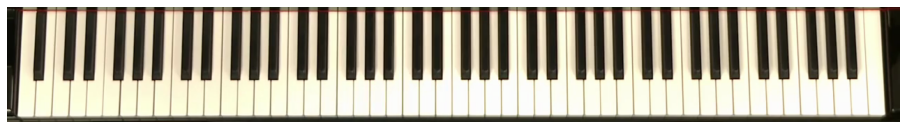

In [7]:
image = get_frame(cap, 814)[1]
image = crop_frame(image, 375, 0, 540-375, image.shape[1], show=True)

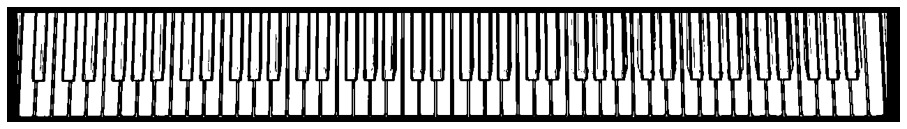

Number of connected components: 88


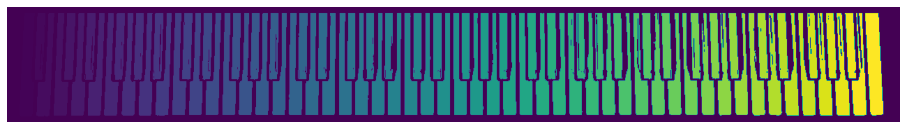

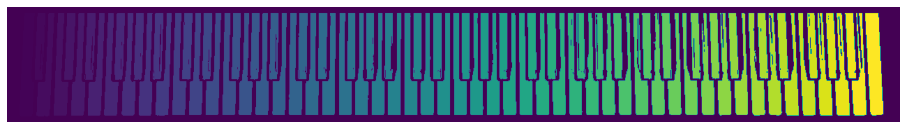

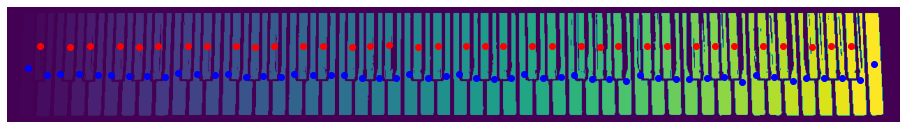

  0%|          | 0/36 [00:00<?, ?it/s]

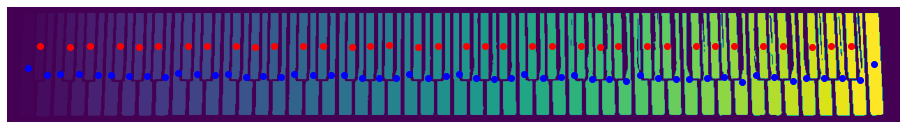

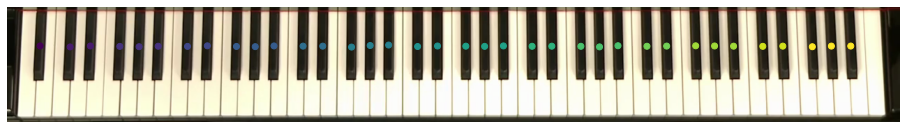

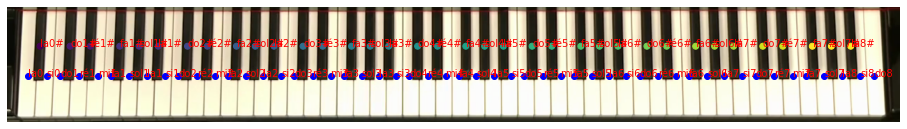

In [8]:
pipe = pipeline(image, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

In [9]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]

def highlight_keys(image, labels, keys, color = [0,255,0], show=False):
    """Highlight keys in an image
    Parameters:
        image: the image to highlight the key in
        labels: the labels of the image
        keys: the number of the key to highlight (can be a list)
        color: color of the highlight (can be a list of colors)"""
    new_image = image.copy()
    if type(keys) == int:
        keys = [keys]
    if type(color[0]) != list and len(color) == 3:
        color = [color]*len(keys)
    for i in range(len(keys)):
        new_image[labels == keys[i]] = color[i]
    if show:
        plt.figure(figsize=(16,10))
        plt.imshow(new_image)
        plt.axis('off')
        plt.show()
    return new_image

def show_frame(frame_number, key):
    _, image = get_frame(cap, frame_number)
    image = crop_frame(image, 375, 0, 540-375, image.shape[1], show=False)
    _ = highlight_keys(image=image, labels=labels, keys = key, color = [g,g,r], show=True)

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        key=widgets.IntSlider(min=0, max=88, step=1, value=10))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, key)>

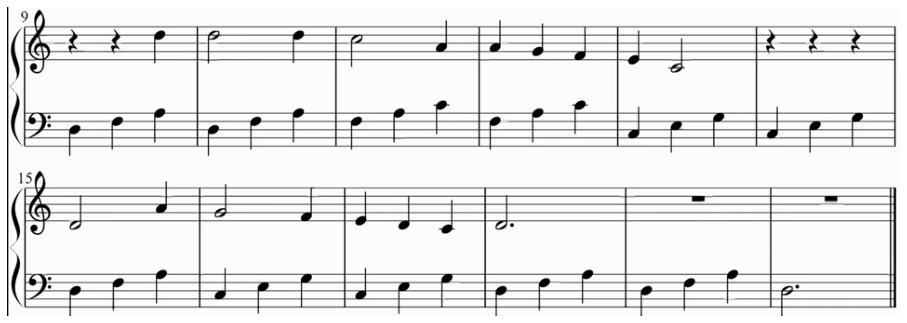

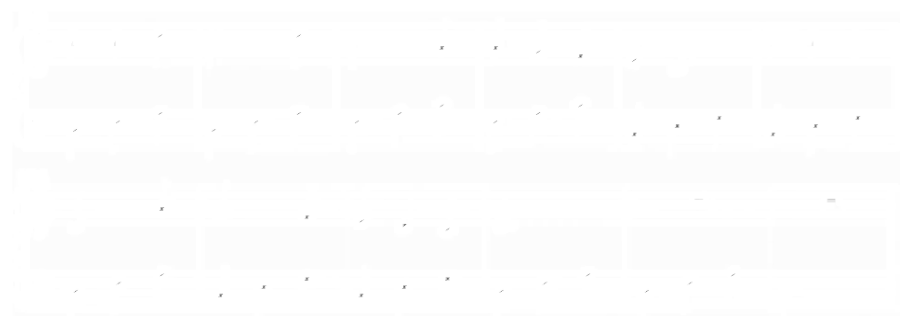

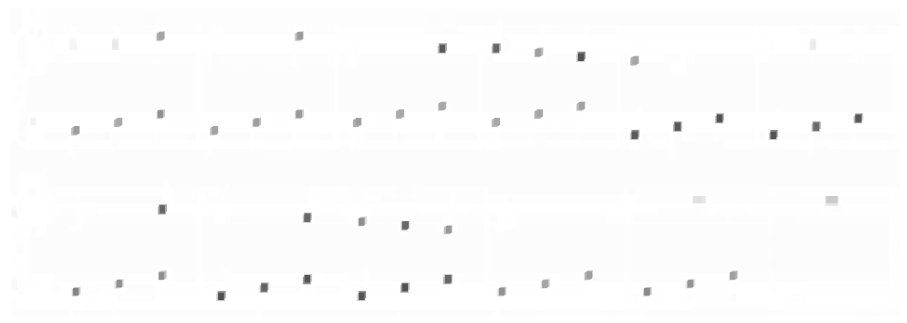

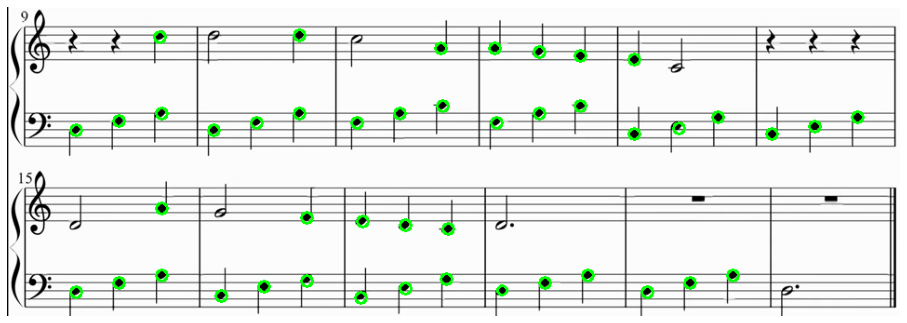

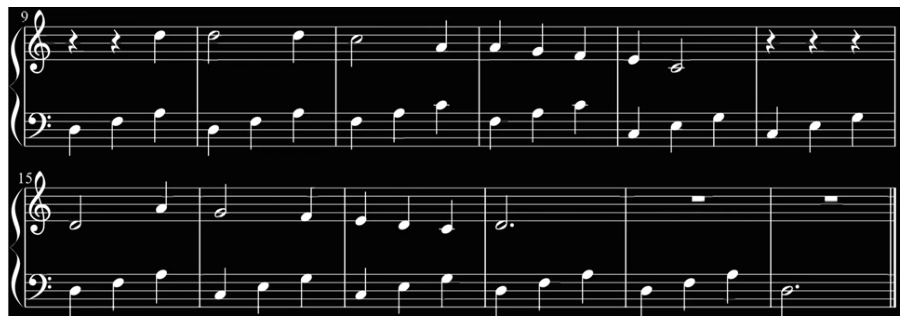

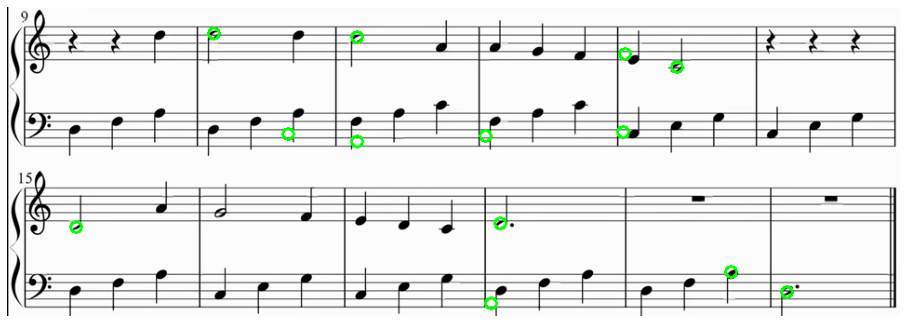

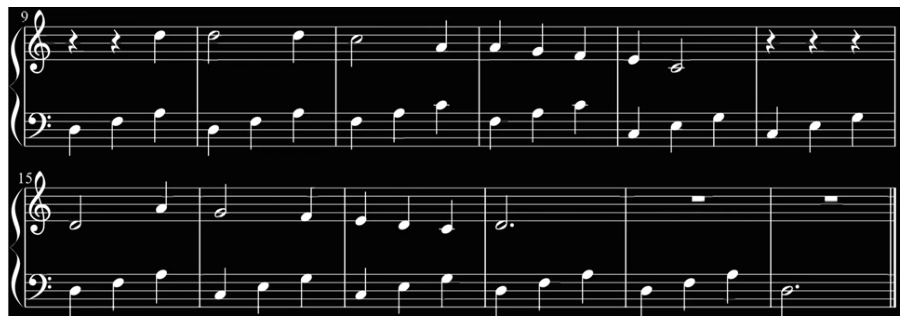

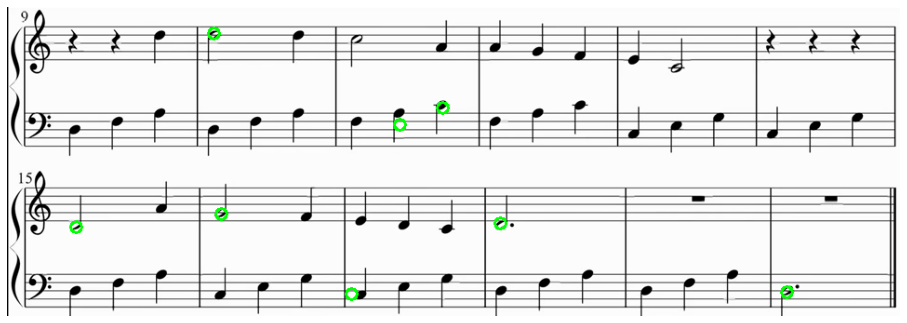

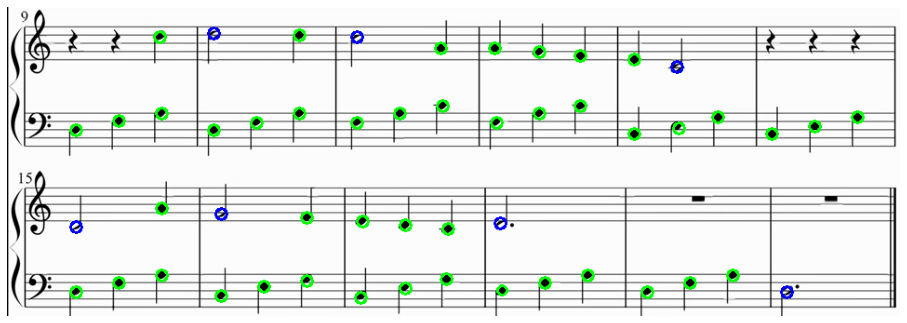

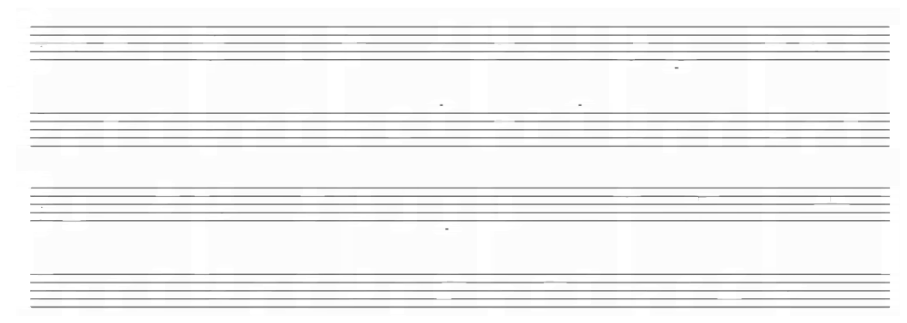

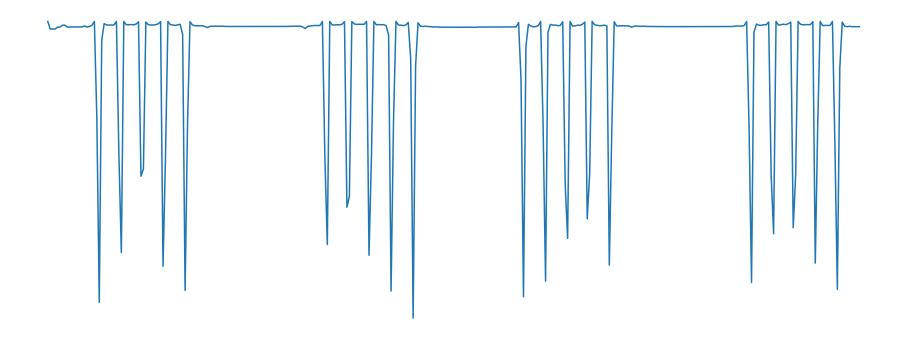

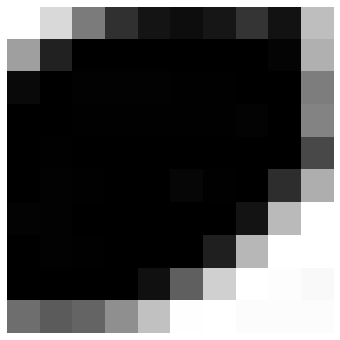

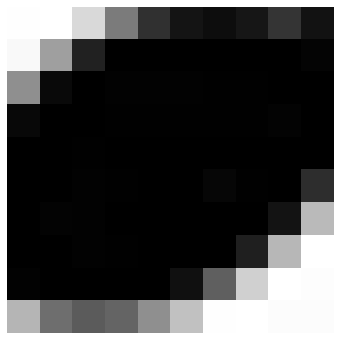

(571, 48)

In [10]:
_, frame = get_frame(cap, 781)
img = crop_frame(frame, 8, 158, 340-8, 960, show=True)
black_circles = get_black_notes(img, show=True)

_, frame = get_frame(cap, 677)
img = crop_frame(frame, 8, 158, 340-8, 960, show=False)
white_circles1 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7, show=True)
white_circles2 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show=True)
white_circles = np.concatenate((white_circles1, white_circles2), axis=1)

all_circles, black_circles, white_circles = all_notes_circles(img, black_circles, white_circles, min_dist=30, show=True)

lines_staff = dilate_img(img, kernel_size_x=1, kernel_size_y=15, iterations=1, show = True)
y_mean = np.mean(np.mean(lines_staff, axis=2), axis=1)
plt.figure(figsize=(16,6))
plt.plot(y_mean)
plt.axis('off')
plt.show()

i = 3
find_real_black_center(img, (black_circles[0][i][0], black_circles[0][i][1]), show=True)

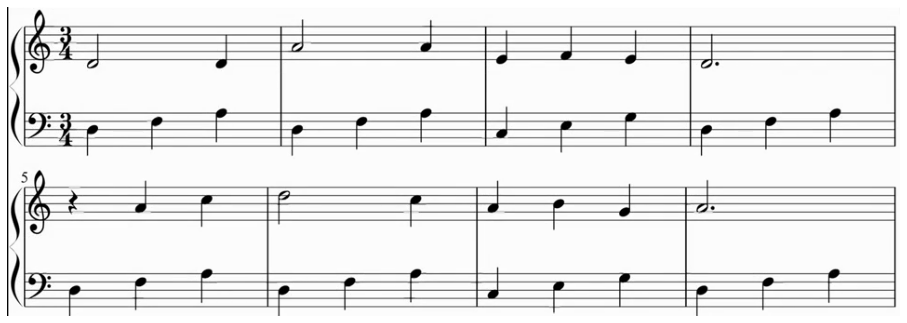

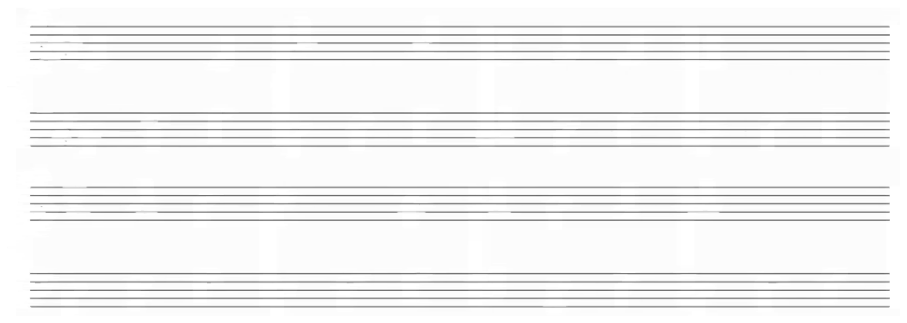

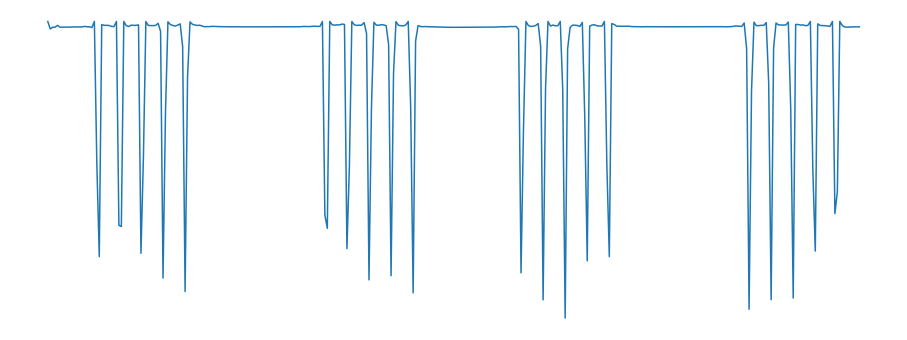

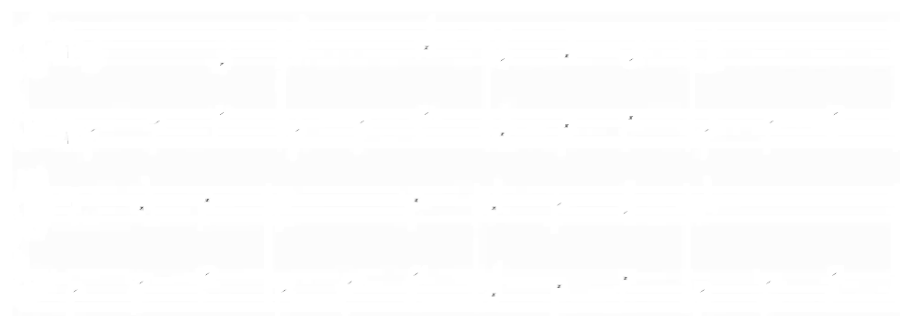

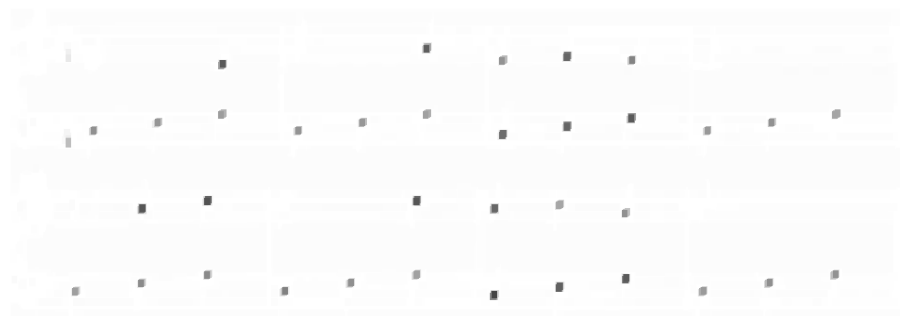

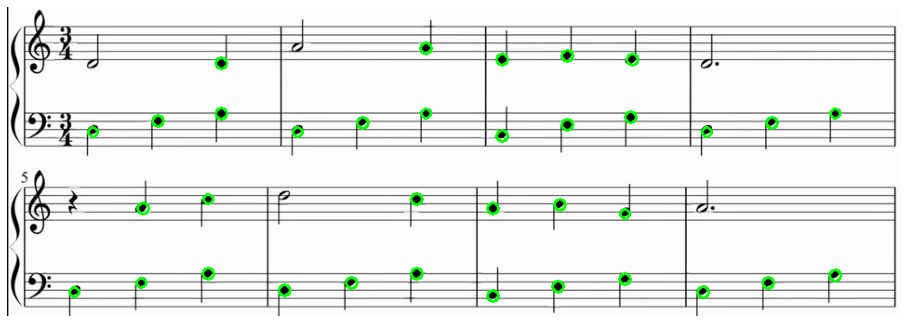

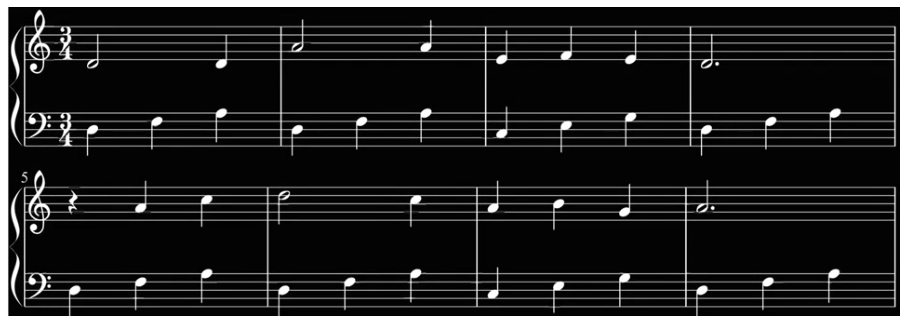

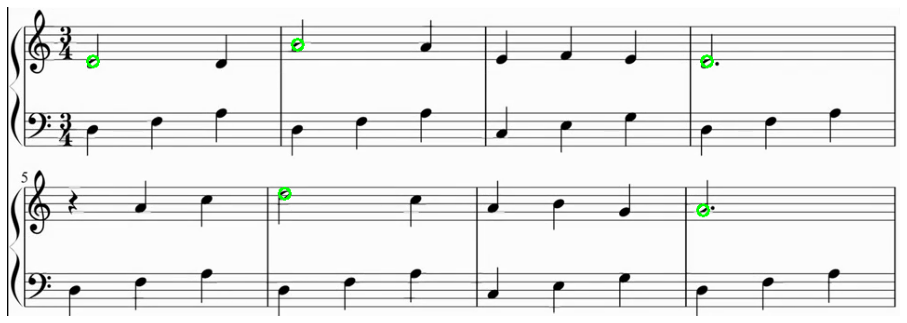

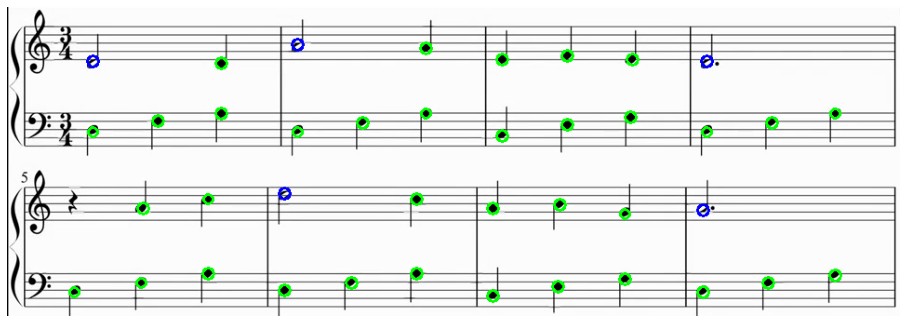

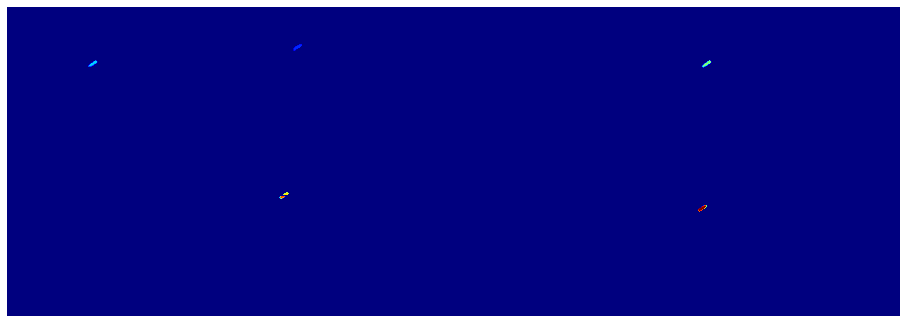

In [11]:
_, frame = get_frame(cap, 10)
img = crop_frame(frame, 8, 158, 340-8, 960, show=True)
lines_staff = dilate_img(img, kernel_size_x=1, kernel_size_y=15, iterations=1, show = True)
y_mean = np.mean(np.mean(lines_staff, axis=2), axis=1)
plt.figure(figsize=(16,6))
plt.plot(y_mean)
plt.axis('off')
plt.show()
index_lines_staff = np.where(y_mean < 200)[0]
group_staff = isolate_index(index_lines_staff)
group_circles_center = pipeline_notes_staff(img, group_staff, show=True)

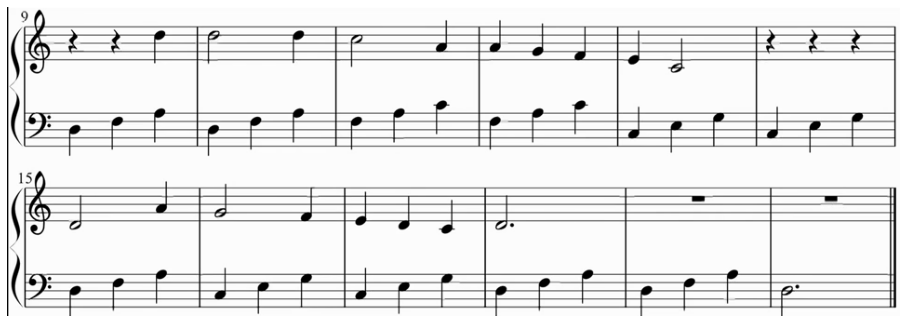

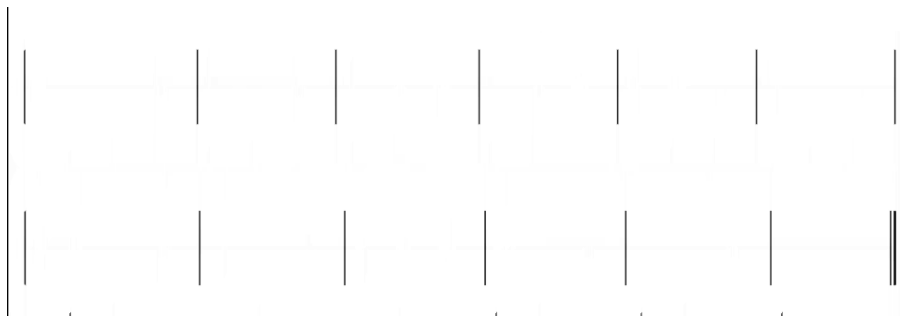

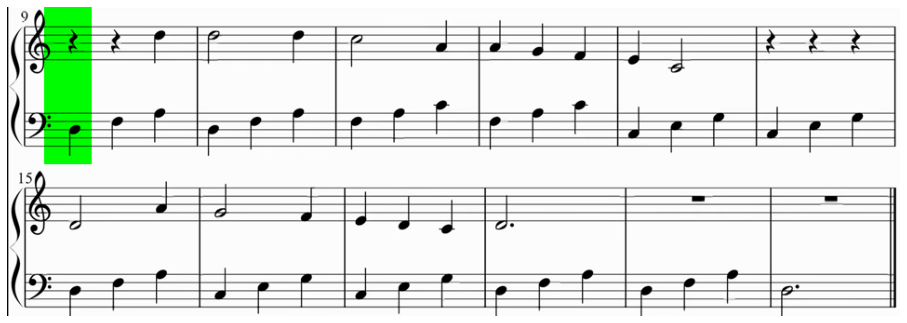

In [12]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = get_frame(cap, 677) # 10,677, 781
img = crop_frame(frame, 8, 158, 340-8, 960, show=True)
index_mesure1, index_mesure2 = pipeline_number_mesure(img, show=True)
highlight_beat(img, 1, 1, index_mesure1, group_staff)

In [13]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]

piano = get_frame(cap, 814)[1]
piano = crop_frame(piano, 375, 0, 540-375, piano.shape[1], show=False)

_, frame = get_frame(cap, 10)
img = crop_frame(frame, 8, 158, 340-8, 960, show=False)
partition1 = pipeline_notes_staff(img, group_staff, show=False)
index_mesure1a, index_mesure1b = pipeline_number_mesure(img, show=False)
group_beat1 = transform_to_beat(partition1, index_mesure1a, index_mesure1b)
note_names1 = circles_to_notes_names(partition1, group_staff)

_, frame = get_frame(cap, 781)
img1 = crop_frame(frame, 8, 158, 340-8, 960, show=False)
_, frame = get_frame(cap, 677)
img2 = crop_frame(frame, 8, 158, 340-8, 960, show=False)
partition2 = pipeline_notes_staff(img1, group_staff, img2, show=False)
index_mesure2a, index_mesure2b = pipeline_number_mesure(img1, show=False)
group_beat2 = transform_to_beat(partition2, index_mesure2a, index_mesure2b)
note_names2 = circles_to_notes_names(partition2, group_staff)

index_mesures = [index_mesure1a, index_mesure1b, index_mesure2a, index_mesure2b]
groups_beat = [group_beat1, group_beat2]
notes_names = [note_names1, note_names2]
imgs = [img, img1]
total_mesures = sum([len(x)-1 for x in index_mesures])
total_beats = total_mesures * 3

In [14]:
def show_partition(beat):
    beat_in_mesure, beat_in_partition, index_mesure, staff, image, group_beat, note_names = beat_to_infos(beat, index_mesures, group_staff, imgs, groups_beat, notes_names)
    notes_at_beat = notes_in_beat(note_names, group_beat, beat_in_partition//3+1, beat_in_mesure)
    print(notes_at_beat)
    highlight_beat(image, beat_in_partition//3+1, beat_in_mesure, index_mesure, staff)
    _ = highlight_notes(image=piano, labels=labels, notes = notes_at_beat[0]+notes_at_beat[1],
                            dict_notes = notes, color = [g,g,r], show=True)
    

interact(show_partition, beat=(1, total_beats, 1))

interactive(children=(IntSlider(value=30, description='beat', max=60, min=1), Output()), _dom_classes=('widget…

<function __main__.show_partition(beat)>

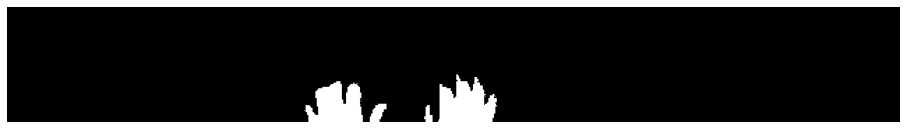

In [15]:
_, frame = get_frame(cap, 10)
frame = crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
frame_hands_isolated = get_hand_region(frame, 30, True)

In [16]:
_, mask = get_frame(cap, 814)
mask = crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pipe = pipeline(mask, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=False)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

Number of connected components: 88


  0%|          | 0/36 [00:00<?, ?it/s]

In [19]:
def highlight_keys(image_hand, image_diff, threshold, labels, centroids):
    new_image = image_hand.copy()
    for i in range(1,89):
        list_testing = get_list_pixels_faster_computation(image_hand, i, labels, centroids, above=10)
        color = np.mean(image_diff[list_testing[0], list_testing[1]], axis=0)
        mean_color = np.mean(color)
        if mean_color > threshold:
            new_image[np.where(labels == i)] = [0,mean_color,0]
        elif mean_color > 50:
            new_image[np.where(labels == i)] = [mean_color,0,0]
    return new_image

def show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, threshold_confidence=150):
    _, frame = get_frame(cap, frame_number)
    frame = crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    if frame is not None:
        plt.figure(figsize=(20,6))
        plt.imshow(pipeline_key_pressed(frame, mask, labels, centroids, threshold_hand, 10, threshold_confidence, show=False))
        plt.axis('off')
        plt.show()
    else:
        print('Frame not found')

interact(show_frame_from_video_and_key_pressed, frame_number=(0, n-1, 1),
            threshold_hand=(0, 255, 1), threshold_confidence=(50, 255, 1))

interactive(children=(IntSlider(value=457, description='frame_number', max=915), IntSlider(value=30, descripti…

<function __main__.show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, threshold_confidence=150)>

In [18]:
def show_frame(frame_number, shift, threshold):
    _, mask = get_frame(cap, 814)
    _, frame = get_frame(cap, frame_number)
    mask = crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
    frame = crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.axis('off')
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=10),
        threshold=widgets.IntSlider(min=0, max=100, step=1, value=30))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, shift, threshold)>